## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-19 21:11:19--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 182489 (178K) [text/plain]
Сохранение в: «CreditScoring.csv»

CreditScoring.csv   100%[===================>] 178,21K  --.-KB/s    за 0,04s   

2021-10-19 21:11:19 (4,74 MB/s) - «CreditScoring.csv» сохранён [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [22]:
categorical = df.dtypes[df.dtypes == 'object'].index
numerical = ['seniority', 'time', 'age', 'expenses', 'income',
             'assets', 'debt', 'price']
categorical, numerical

(Index(['home', 'marital', 'records', 'job'], dtype='object'),
 ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'price'])

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [16]:
from sklearn.model_selection import train_test_split

In [19]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [31]:
scores = []

for n in numerical:
    auc = roc_auc_score(y_train, df_train[n].values)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[n].values)
    scores.append(auc)
    
scores_df = pd.DataFrame()
scores_df['name'] = numerical
scores_df['score'] = scores

In [36]:
scores_df.sort_values('score', ascending=False)

,name,score
0,seniority,0.709378
4,income,0.682007
5,assets,0.648604
2,age,0.573293
1,time,0.560866
6,debt,0.504783
7,price,0.504333
3,expenses,0.500918


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

#### Answer: seniority

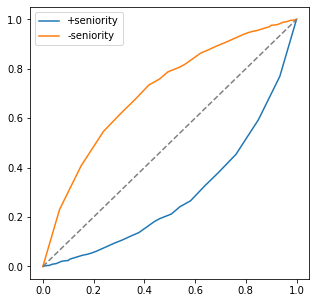

In [46]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.seniority)
plt.plot(fpr, tpr, label='+seniority')

fpr, tpr, _ = roc_curve(y_train, -df_train.seniority)
plt.plot(fpr, tpr, label='-seniority')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [51]:
columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [54]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [59]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[columns].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [70]:
val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, y_pred), 3)

0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [76]:
threshold = np.arange(0, 1.01, 0.01)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [80]:
p_scores = []
r_scores = []

for t in threshold:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    
    tn = (predict_negative & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    p_scores.append(p)
    r_scores.append(r)

<ipython-input-80-a8f2ede944d6>:14: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


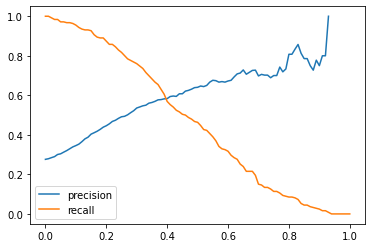

In [81]:
plt.plot(threshold, p_scores, label='precision')
plt.plot(threshold, r_scores, label='recall')

plt.legend()
plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

#### Answer: 0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [86]:
scores = []

for t in threshold:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    
    tn = (predict_negative & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1 = 2 * p * r / (p + r)
    
    scores.append((t, p, r, f1))

<ipython-input-86-ba72d810c002>:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


In [87]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'f1'])

In [98]:
df_scores.iloc[df_scores.f1.sort_values(ascending=False).index]

,threshold,precision,recall,f1
30,0.30,0.535817,0.760163,0.628571
31,0.31,0.541176,0.747967,0.627986
32,0.32,0.546828,0.735772,0.627383
34,0.34,0.560261,0.699187,0.622061
33,0.33,0.550000,0.715447,0.621908
...,...,...,...,...
96,0.96,NaN,0.000000,NaN
97,0.97,NaN,0.000000,NaN
98,0.98,NaN,0.000000,NaN
99,0.99,NaN,0.000000,NaN


#### Answer: 0.3

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [99]:
from sklearn.model_selection import KFold

In [105]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [101]:
def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [102]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.default.values
    y_val = df_val.default.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [104]:
np.std(scores)

0.01460989648482707

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

#### Answer: 0.014

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [106]:
for c in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %3f' %(c, np.mean(scores), np.std(scores)))

C=0.01 0.808 +- 0.011834
C=0.1 0.813 +- 0.013744
C=1 0.814 +- 0.014610
C=10 0.814 +- 0.014619


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

#### Answer: 1

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.